In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, scale, OneHotEncoder, LabelEncoder, LabelBinarizer
import feather
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
ssc = StandardScaler()

In [12]:
data_table = '/stor/work/Lambowitz/cdw2854/bench_marking/DEgenes/fc_table.feather'
df = feather.read_dataframe(data_table)      \
    .query('map_type == "Salmon"') \
    .assign(label = lambda d: np.where(abs(d.error) > np.mean(d.error) + np.std(d.error), 'Bad', 'Good'))\
    .assign(gene_length = lambda d: d.gene_length.transform(np.log2))
df.head()

,id,map_type,baseMean_AB,baseMean_CD,logFC_AB,logFC_CD,padj_AB,padj_CD,pvalue_AB,pvalue_CD,...,analytic_type,name,type,X99.,X90.,X75.,labeling,pipeline_type,gene_length,label
2,18S_rRNA,Salmon,62629.790744,55637.702015,-0.759279,-0.164800,4.691468e-01,8.523979e-01,3.286727e-01,7.367827e-01,...,Alignment-free,18S_rRNA,rRNA,6999.849208,1287.844881,240.928245,Top 1%,2.0,10.868823,Good
6,28S_rRNA,Salmon,798166.090737,707175.161931,-1.137234,-0.471314,2.146249e-02,1.070800e-01,8.702379e-03,4.453984e-02,...,Alignment-free,28S_rRNA,rRNA,6999.849208,1287.844881,240.928245,Top 1%,2.0,12.297490,Good
10,5.8S_rRNA,Salmon,6045.764961,5488.466527,-0.359951,0.063818,4.767957e-03,7.224506e-01,1.706178e-03,5.560235e-01,...,Alignment-free,5.8S_rRNA,rRNA,6999.849208,1287.844881,240.928245,Top 10%,2.0,7.285402,Good
14,5S_rRNA,Salmon,445.934258,435.313263,-0.466092,-0.056181,1.711052e-02,8.365954e-01,6.784609e-03,7.126044e-01,...,Alignment-free,5S_rRNA,rRNA,6999.849208,1287.844881,240.928245,Top 25%,2.0,6.906891,Good
18,ENSG00000000003,Salmon,739.786537,767.338386,1.999397,0.713120,2.585749e-50,4.131737e-07,1.775168e-51,6.266867e-08,...,Alignment-free,TSPAN6,Protein coding,6999.849208,1287.844881,240.928245,Top 25%,2.0,13.653069,Good


In [21]:
tdf = pd.concat([df[['label','baseMean_CD','gene_length']],
               pd.get_dummies(df['type'])], 
              axis=1)\
    .rename(columns = {'baseMean_CD':'Mean abundance',
                      'gene_length':'Gene length'})
tdf.head()

,label,Mean abundance,Gene length,Antisense,ERCC,Mt,Other ncRNA,Other sncRNA,Protein coding,miRNA,rRNA,snoRNA,vaultRNA
2,Good,55637.702015,10.868823,0,0,0,0,0,0,0,1,0,0
6,Good,707175.161931,12.297490,0,0,0,0,0,0,0,1,0,0
10,Good,5488.466527,7.285402,0,0,0,0,0,0,0,1,0,0
14,Good,435.313263,6.906891,0,0,0,0,0,0,0,1,0,0
18,Good,767.338386,13.653069,0,0,0,0,0,1,0,0,0,0


In [17]:
def plot_error(df, ax):
    for label, ldf in df.groupby('label'):
        sns.distplot(ldf.error, label=label, ax = ax)
    sns.distplot(df.error, label = 'Total', ax = ax)
    sns.despine()
    ax.legend()
    return 0

In [6]:
def plot_roc(Y_test, pred_y, ax):
    auc = roc_auc_score(Y_test, pred_y[:,1])
    fpr, tpr, _ = roc_curve(Y_test, pred_y[:,1])
    ax.plot(fpr,tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('Ttrue Positive Rate')
    ax.text(0.6,0.2, 'AUC: %.3f' %(auc))
    ax.plot([0,1],[0,1], color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return 0

def capitalize(title):
    if not title:
        return ''
    return title[0].upper() + title[1:]

def plot_importance(rf, columns, ax):
    import_df = pd.DataFrame({'import':rf.feature_importances_*100,
              'feature':columns}) \
        .assign(feature = lambda d: d.feature.str.replace('_',' '))\
        .assign(feature = lambda d: map(capitalize, d.feature))\
        .sort_values('import', ascending=False)
    import_df.plot(kind='bar', ax = ax)
    ax.legend().set_visible(False)
    ax.set_xlabel(' ')
    ax.set_ylabel('Importance (%)')
    ax.set_xticklabels(import_df.feature, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [7]:
def optimize_rf(X, Y):
    rf = RandomForestClassifier()
    param_grid = {'n_estimators':np.arange(10,50),
                 'max_features':np.arange(2,7)}
    cv = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
    cv.fit(X,Y)
    return cv.best_params_
    

def train_rf(df, columns):
    X = df[columns]
    lb = LabelBinarizer()
    Y = lb.fit_transform(df.label).flatten()
    params = optimize_rf(X,Y)
    rf = RandomForestClassifier(n_estimators=params['n_estimators'], 
                                max_features = params['max_features'], n_jobs=-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    rf.fit(X_train, Y_train)
    pred_y = rf.predict_proba(X_test)
    return rf, pred_y, Y_test

In [22]:
columns = tdf.columns[~tdf.columns.str.contains('label')]
rf, pred_y, Y_test = train_rf(tdf, columns)

Saved:  /stor/work/Lambowitz/cdw2854/bench_marking/figures/roc_fc_error.png


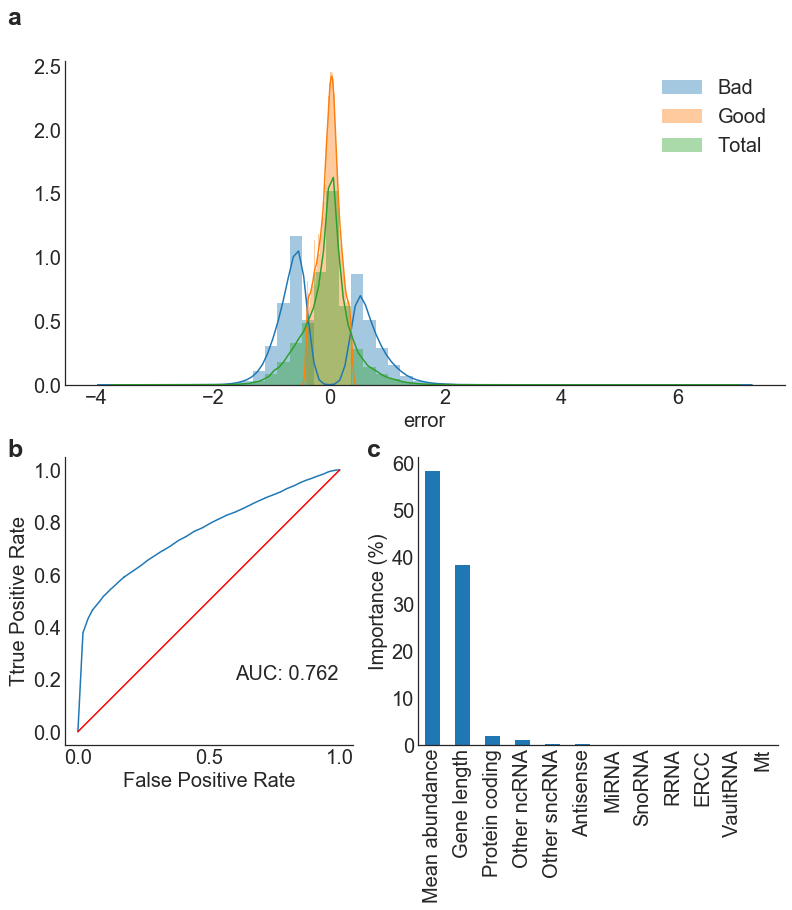

In [23]:
figurepath = '/stor/work/Lambowitz/cdw2854/bench_marking/figures'
figurename = figurepath + '/roc_fc_error.png'

FONT_SIZE = 20

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)

sns.set_style('white')
fig = plt.figure(figsize=(10,10))
ax_gene = fig.add_axes([0.08,0.5,1,0.45])
ax_roc = fig.add_axes([0.08,0,0.4,0.4])
ax_importance = fig.add_axes([0.57, 0,0.5,0.4])
plot_error(df, ax_gene)
plot_roc(Y_test, pred_y, ax_roc)
plot_importance(rf, columns, ax_importance)
fig.text(0,1,'a', weight='bold', fontsize=25)
fig.text(0,0.4,'b',weight='bold', fontsize=25)
fig.text(0.5,0.4,'c',weight='bold', fontsize=25)
plt.savefig(figurename, transparent=True, bbox_inches='tight')
print 'Saved: ', figurename

In [11]:
df.head()

,label,baseMean_CD,gene_length,Antisense,ERCC,Mt,Other ncRNA,Other sncRNA,Protein coding,miRNA,rRNA,snoRNA,vaultRNA
2,Good,55637.702015,10.868823,0,0,0,0,0,0,0,1,0,0
6,Good,707175.161931,12.297490,0,0,0,0,0,0,0,1,0,0
10,Good,5488.466527,7.285402,0,0,0,0,0,0,0,1,0,0
14,Good,435.313263,6.906891,0,0,0,0,0,0,0,1,0,0
18,Good,767.338386,13.653069,0,0,0,0,0,1,0,0,0,0


In [45]:
df.query('samplename == "Sample_A"').shape

(19344, 7)